<a href="https://colab.research.google.com/github/rgprado/SeriesTemporais/blob/main/Series_Temporais_aula1_202201_Rodrigo_Prado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Análise de Séries Temporais
 
 **Professor**: Domingos Santos

 **Aluno**: Rodrigo Prado

**Atividade 1**:

 - selecionar 2 séries: uma financeira e uma adicional (sugestão, uma disponível no pydataset)
 - plot da média movél 
 - análise de quais componentes foram observados nas séries (Tendência, Sazonalidade e ciclos)
 - Calcularem o ACF e PACF das séries
 - analisar a série "sem_nome", identificar os componentes e defina essa série 

**Atividade 2**: para cada uma das séries:

- aplicar o KPSSTest;
- caso necessite aplique a diferenciação;
- avaliação se precisa aplicar mais diferenciações;
- aplicar o auto.arima nas duas séries selecionadas, testar a abordagem direta (sem reajustar o modelo), e one step (ajustando o arima em cada passo)



In [2]:
!pip install yfinance pydataset pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 79.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 98.6 MB/s eta 0:00:00
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939432 sha256=b28ede30c248a9517053503feb376a4a083901744e2c

In [3]:
import yfinance as yf
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (20,10)

initiated datasets repo at: /root/.pydataset/


In [4]:
example_ma = [1,2,3,4,5,6,7,8,9,10]
ma_size=2

for i in range(ma_size, len(example_ma)):
  consider_val = example_ma[i-ma_size:i]
  print(f'valores considerados: {consider_val}, MA {np.mean(consider_val)}, valor atual {i}')

valores considerados: [1, 2], MA 1.5, valor atual 2
valores considerados: [2, 3], MA 2.5, valor atual 3
valores considerados: [3, 4], MA 3.5, valor atual 4
valores considerados: [4, 5], MA 4.5, valor atual 5
valores considerados: [5, 6], MA 5.5, valor atual 6
valores considerados: [6, 7], MA 6.5, valor atual 7
valores considerados: [7, 8], MA 7.5, valor atual 8
valores considerados: [8, 9], MA 8.5, valor atual 9


**Definição da função para cálculo da média movel**

In [5]:
def show_trend(ts, ma_size):
  to_show = pd.DataFrame()

  to_show['serie'] = ts.values[ma_size:]
  to_show['MA']  = ts.rolling(ma_size).mean().values[ma_size:]
  to_show.plot()
  plt.show()

**Definição da Funçao DIFF**


In [6]:
def difference(ts, interval=1):
  diff = list()

  for t in range(interval, ts.shape[0]):
    value = ts[t] - ts[t - interval]
    diff.append(value)


  return pd.Series(diff)

**Definição da função para busca de ações**


In [7]:
def get_yfinance(id_name):
  df = yf.Ticker(id_name)
  return  df.history(period="max")

**Definição da função para predict do modelo ARIMA**




In [109]:
def arima_fit_predict(ts, m, test_size):
  ts_train = ts[0:-test_size]
  ts_test = ts[-test_size:]

  print(f'training shape {ts_train.shape}')
  print(f'test shape {ts_test.shape}')

  model = auto_arima(ts_train.values, # X=None,
                    start_p=2, d=None, start_q=2, 
                    max_p=5, max_d=2, max_q=5, start_P=1, D=None,
                    start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=m, trace=True, maxiter=10)
 
  direct_prev = model.predict(test_size)

  prevs_1_step = []
  for i in tqdm(ts_test):
    prevs_1_step.append(model.predict(1)[0])
    model.update(i)

  df_result = pd.DataFrame({
                          'arima_direct': direct_prev ,
                          'arima_1step': prevs_1_step,
                          'real': ts_test.values
                          })
  return df_result

**Definição da função para predict com horizonte do modelo ARIMA**

In [9]:
def arima_horizon_fit_predict(ts, m, test_size, horizon):
  horizon = horizon

  ts_train = ts[0:-(test_size+(horizon-1))]
  ts_test = ts[-(test_size+(horizon-1)):]

  print(f'training shape {ts_train.shape}')
  print(f'test shape {ts_test.shape}')
  model = auto_arima(ts_train.values, # X=None,
                      start_p=2, d=None, start_q=2, 
                      max_p=5, max_d=2, max_q=5, start_P=1, D=None,
                      start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=m, trace=True, maxiter=10)

  prevs_step = []
  count = 0
  for i in tqdm(ts_test):
    print(f'fim do treino {count+ts_train.shape[0]}')
    prevs_step.append(model.predict(horizon)[horizon-1])
    model.update(i)
    count= count  +1

  return prevs_step[0:-(horizon-1)]

##Definição de função para plot da série e diferentes previsões

In [10]:
def plot_predict(ts, ts_predict, test_size):
  TEST_SIZE = test_size
  data = ts
  train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
  x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
  print(train.shape, x_train.shape, test.shape, x_test.shape)

  arima_direct = ts_predict['arima_direct']
  arima_1step = ts_predict['arima_1step']
  real = ts_predict['real']
  arima_10step = ts_predict['arima_10step']

  fig, ax = plt.subplots(1, 1, figsize=(25, 7))
  ax.plot(x_train, train)
  ax.plot(x_test, arima_direct)
  ax.plot(x_test, arima_1step)
  ax.plot(x_test, arima_10step)
  ax.plot(x_test, real)
  plt.show()

## definição da função para cálculo do MSE##

In [11]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

## Análise Financeira

In [12]:
df_berkshire = get_yfinance('BRK-A')

In [13]:
df_berkshire

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17 00:00:00-05:00,290.0,310.0,290.0,290.0,10000,0.0,0.0
1980-03-18 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
1980-03-19 00:00:00-05:00,290.0,310.0,290.0,290.0,20000,0.0,0.0
1980-03-20 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
1980-03-21 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-18 00:00:00-05:00,477497.0,479229.0,465831.0,466260.0,4100,0.0,0.0
2023-01-19 00:00:00-05:00,462498.0,465065.0,460233.0,461950.0,3600,0.0,0.0
2023-01-20 00:00:00-05:00,463914.0,469755.0,460635.0,469645.0,3800,0.0,0.0


**Análise:**

No gráfico de fechamento das ações da Berkshire Hathaway podemos observar uma tendência positiva na valorização das ações.

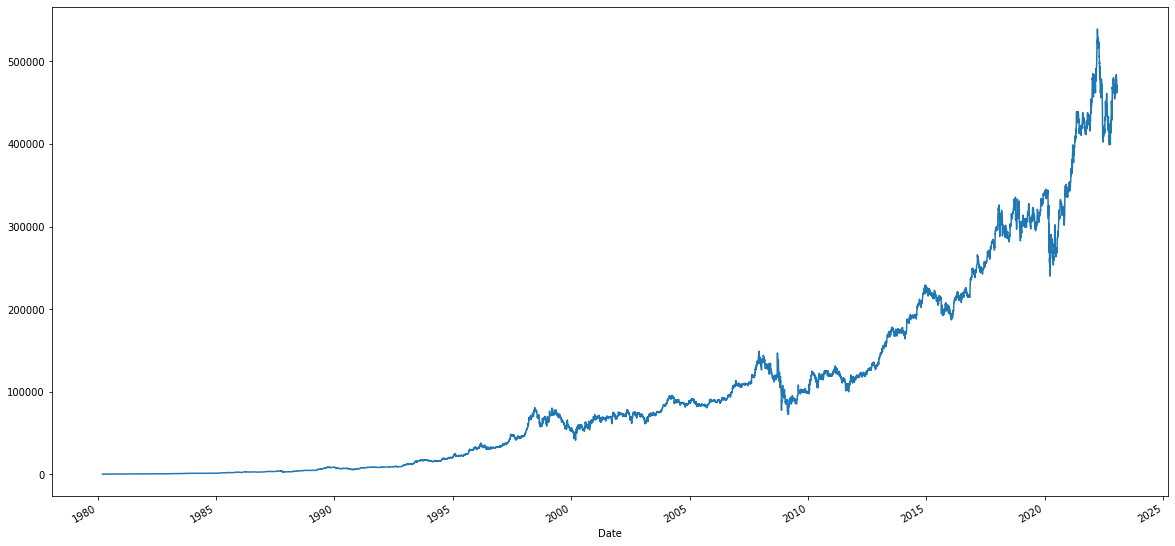

In [14]:
df_berkshire['Close'].plot()

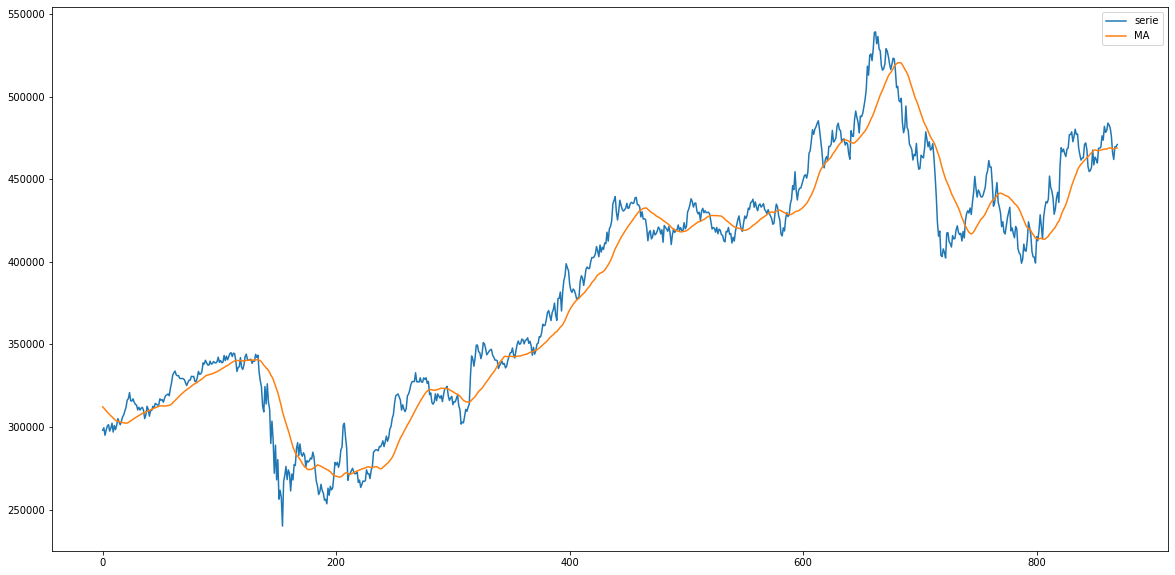

In [15]:
ts_berkshire = df_berkshire['Close'].iloc[-900:]
ma_size=30
show_trend(ts_berkshire, ma_size)

**Análise**:

No gráfico de correlação acumulada, aparentemente existe uma correlação muito forte entre os dias, analisado com um lag de 20.

Mas fazendo a análise parcial da correlação, podemos ver que o gráfico apresenta uma característica "Random Walk", correlação forte com t-1, porém o restante bastante variado e com média próxima de zero.

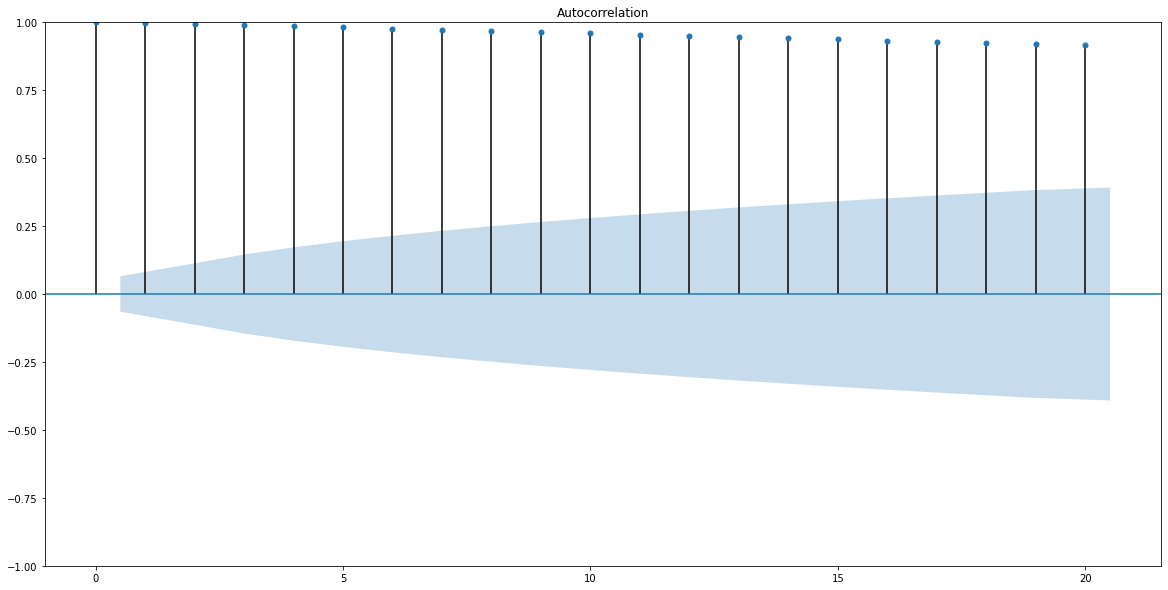

In [16]:
sm.graphics.tsa.plot_acf(ts_berkshire.values.squeeze(), lags=20)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


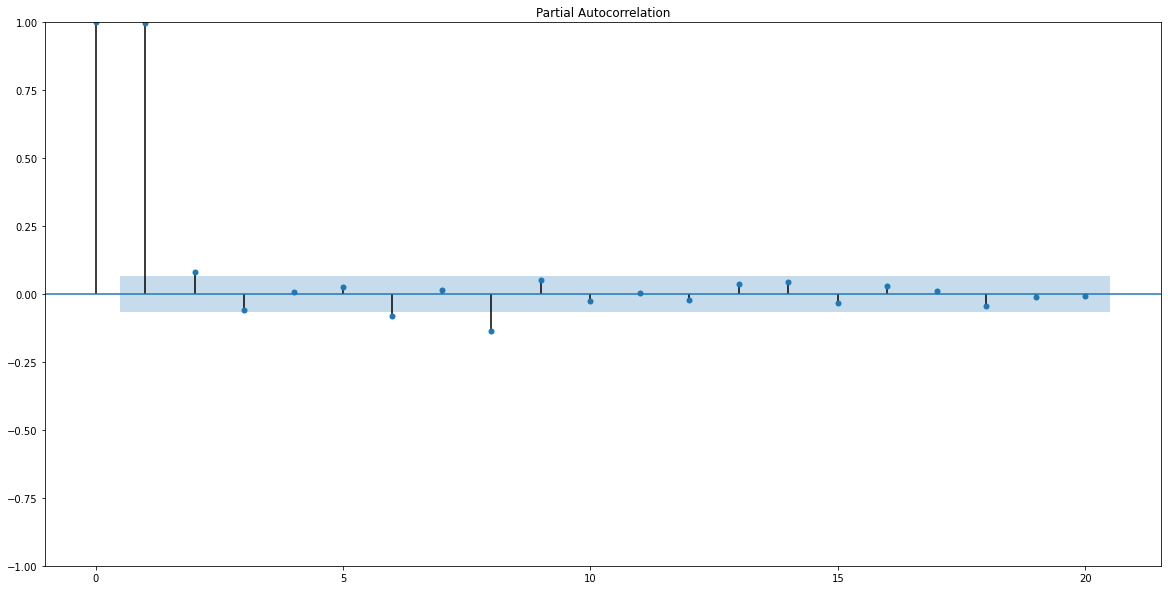

In [17]:
sm.graphics.tsa.plot_pacf(ts_berkshire.values.squeeze(), lags=20)

plt.show()

**Análise com função KPSSTest - Berkshire Hathaway**

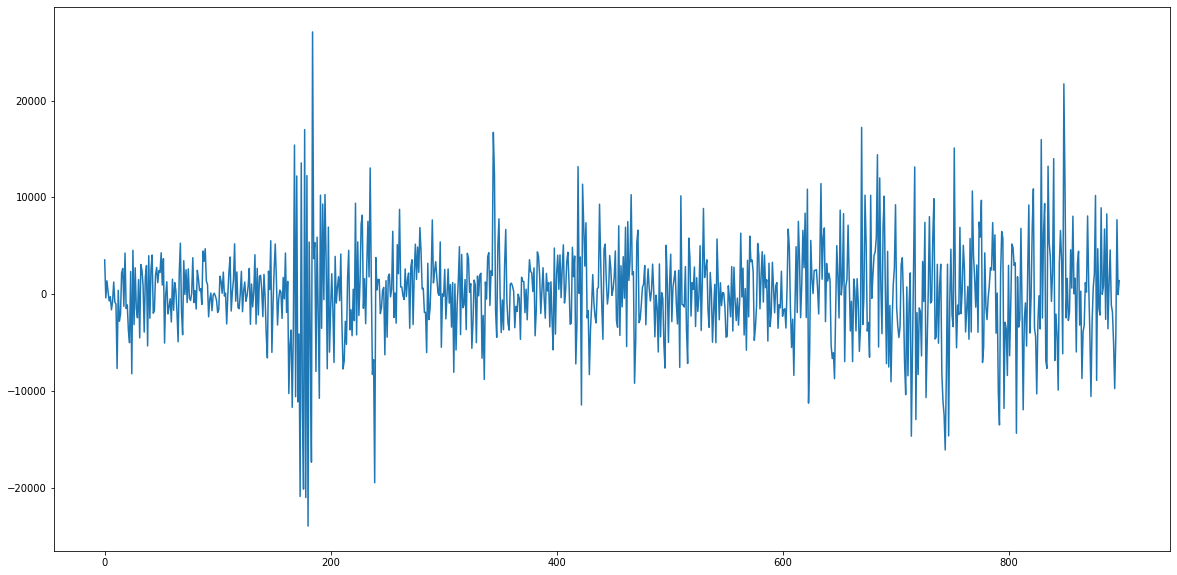

In [18]:
diff_finance = difference(ts_berkshire) # ou ts.diff()
diff_finance.plot()
plt.show()

In [19]:
kps = KPSSTest()
kps.should_diff(df_berkshire['Close'])

(0.01, True)

**Análise**

Plot do ACF para o primeiro diff da série. 

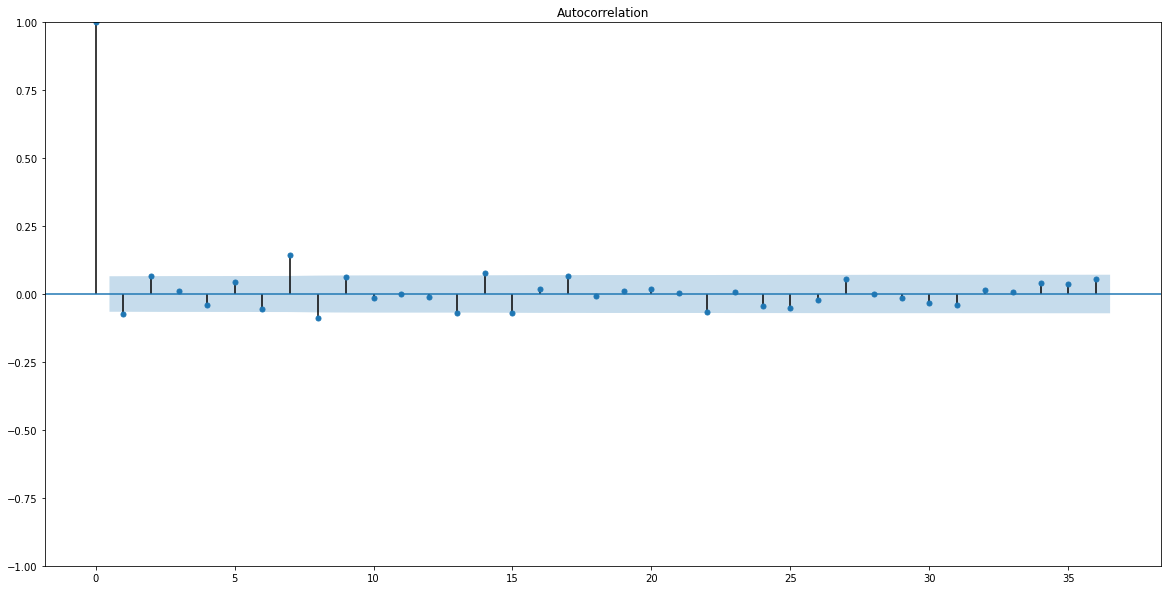

In [20]:
sm.graphics.tsa.plot_acf(diff_finance, lags=36)
plt.show()

**Análise**

Plot do PACF para o primeiro diff da série. 

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


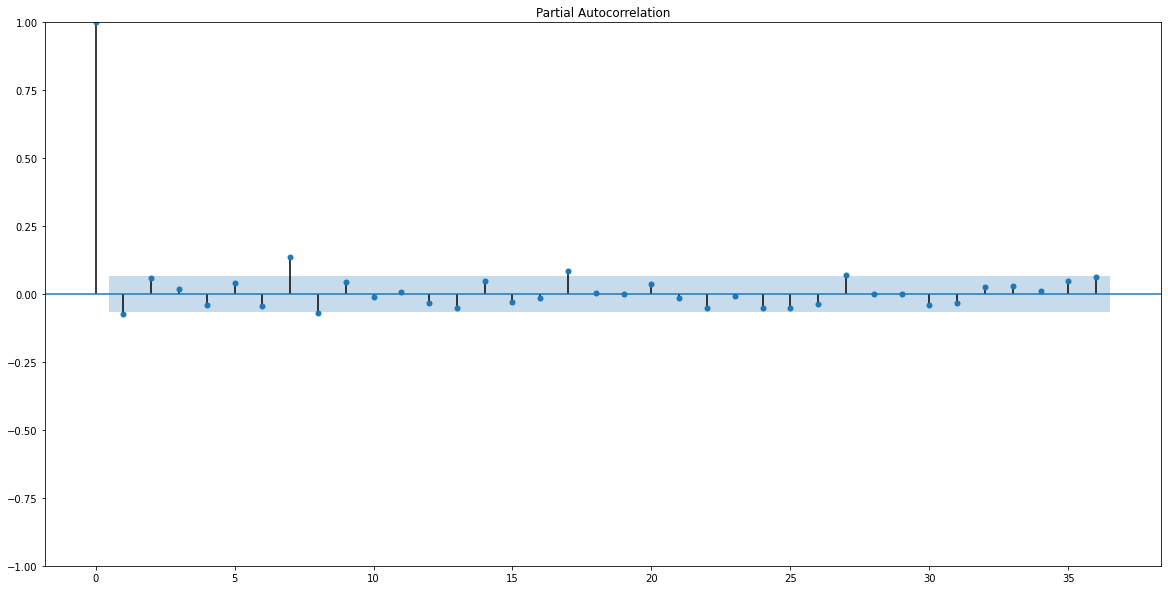

In [21]:
sm.graphics.tsa.plot_pacf(diff_finance, lags=36)
plt.show()

**Análise**

Verificando se é necessário fazer mais um diff na série. O retorno indica que sim.

In [22]:
kps.should_diff(diff_finance)

(0.1, False)

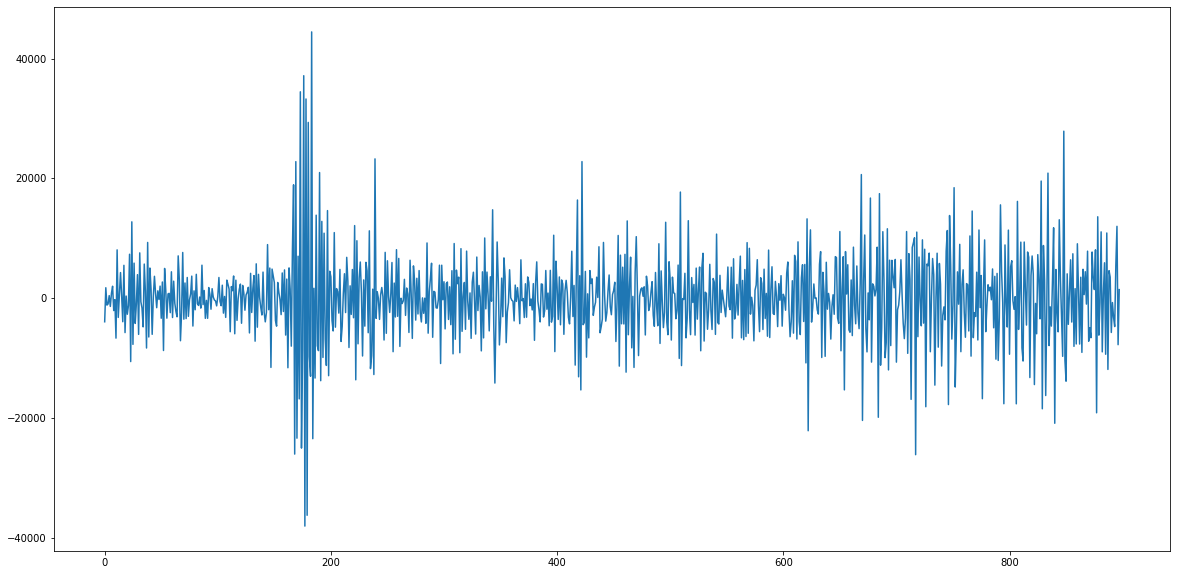

In [23]:
diff_finance2 = difference(diff_finance) # ou ts.diff()
diff_finance2.plot()
plt.show()

**Análise gráfica**

Plot do ACF e PACF da segunda diferença

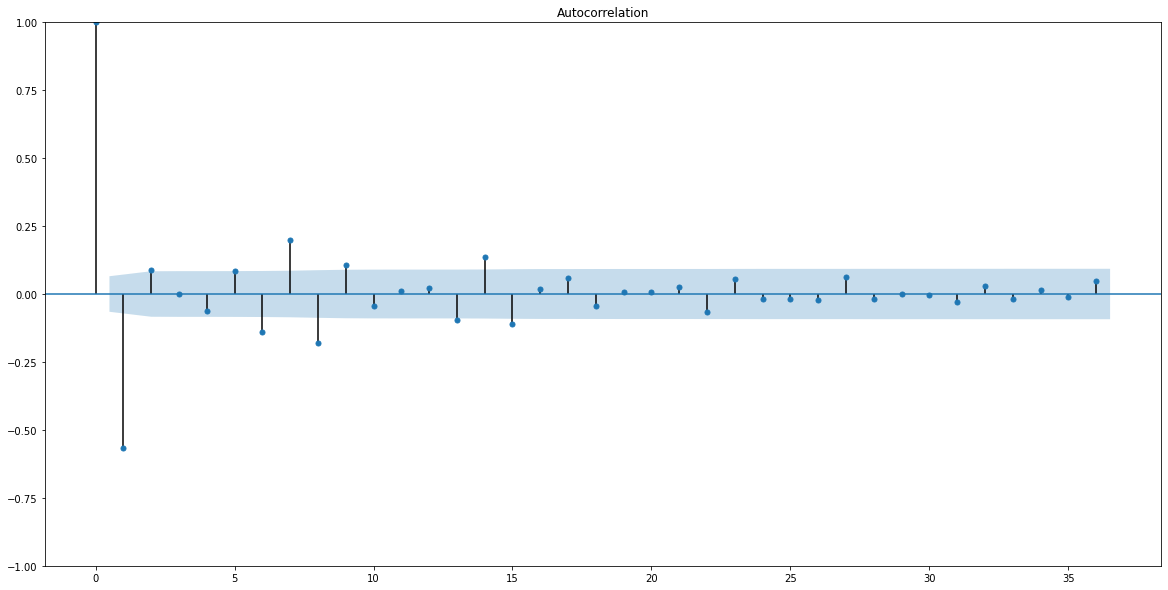

In [24]:
sm.graphics.tsa.plot_acf(diff_finance2, lags=36)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


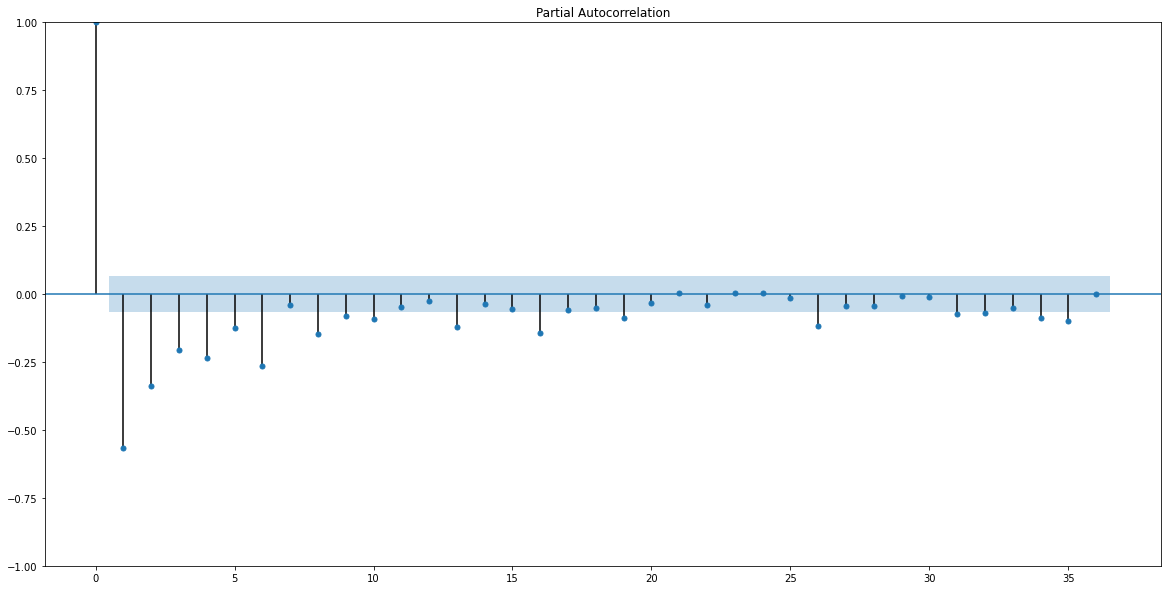

In [25]:
sm.graphics.tsa.plot_pacf(diff_finance2, lags=36)
plt.show()

**Análise**

Novo KPSSTest, agora retorno falso.

De acordo com a função de KPSSTest, o dados de fechamento da Berkshire precisariam da função diff e mesmo depois da primeira passagem, ainda seria necessário fazer mais uma differença.

In [26]:
kps.should_diff(diff_finance2)

(0.1, False)

##Criação do modelo com auto_arima##

Para criação do modelo não foram utilizados todos os dados da série temporal, somente os últimos 900.

In [27]:
auto_arima(ts_berkshire, # X=None,
           start_p=2, d=None, start_q=2, 
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17938.563, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17931.280, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17933.103, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17933.098, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17930.248, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17934.999, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.782 seconds


ARIMA(maxiter=10, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##Fazendo predict de 1 step com auto_arima##

In [28]:
df_arima_berkshire = arima_fit_predict(ts_berkshire, 1, 90)

training shape (810,)
test shape (90,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16097.900, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16091.072, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16092.858, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16092.845, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16089.581, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16094.594, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.539 seconds


100%|██████████| 90/90 [00:01<00:00, 68.00it/s]


##Fazendo predict de 10 steps (horizon) com auto_arima##

In [29]:
df_arima_berkshire['arima_10step'] = arima_horizon_fit_predict(ts_berkshire, 1, 90, 10)

training shape (801,)
test shape (99,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15914.827, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15908.082, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15909.900, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15909.887, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15906.608, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15911.644, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.628 seconds


  6%|▌         | 6/99 [00:00<00:01, 52.74it/s]

fim do treino 801
fim do treino 802
fim do treino 803
fim do treino 804
fim do treino 805
fim do treino 806
fim do treino 807
fim do treino 808
fim do treino 809
fim do treino 810
fim do treino 811
fim do treino 812
fim do treino 813


 22%|██▏       | 22/99 [00:00<00:01, 71.30it/s]

fim do treino 814
fim do treino 815
fim do treino 816
fim do treino 817
fim do treino 818
fim do treino 819
fim do treino 820
fim do treino 821
fim do treino 822
fim do treino 823
fim do treino 824
fim do treino 825
fim do treino 826
fim do treino 827
fim do treino 828


 38%|███▊      | 38/99 [00:00<00:01, 59.19it/s]

fim do treino 829
fim do treino 830
fim do treino 831
fim do treino 832
fim do treino 833
fim do treino 834
fim do treino 835
fim do treino 836
fim do treino 837
fim do treino 838


 45%|████▌     | 45/99 [00:00<00:01, 49.28it/s]

fim do treino 839
fim do treino 840
fim do treino 841
fim do treino 842
fim do treino 843
fim do treino 844
fim do treino 845
fim do treino 846


 52%|█████▏    | 51/99 [00:00<00:01, 46.53it/s]

fim do treino 847
fim do treino 848
fim do treino 849
fim do treino 850
fim do treino 851
fim do treino 852
fim do treino 853
fim do treino 854


 62%|██████▏   | 61/99 [00:01<00:00, 42.53it/s]

fim do treino 855
fim do treino 856
fim do treino 857
fim do treino 858
fim do treino 859
fim do treino 860
fim do treino 861
fim do treino 862


 67%|██████▋   | 66/99 [00:01<00:00, 38.03it/s]

fim do treino 863
fim do treino 864
fim do treino 865
fim do treino 866
fim do treino 867
fim do treino 868


 75%|███████▍  | 74/99 [00:01<00:00, 32.98it/s]

fim do treino 869
fim do treino 870
fim do treino 871
fim do treino 872
fim do treino 873
fim do treino 874
fim do treino 875


 80%|███████▉  | 79/99 [00:01<00:00, 35.87it/s]

fim do treino 876
fim do treino 877
fim do treino 878
fim do treino 879
fim do treino 880
fim do treino 881
fim do treino 882
fim do treino 883


 89%|████████▉ | 88/99 [00:02<00:00, 35.96it/s]

fim do treino 884
fim do treino 885
fim do treino 886
fim do treino 887
fim do treino 888
fim do treino 889
fim do treino 890
fim do treino 891
fim do treino 892


100%|██████████| 99/99 [00:02<00:00, 42.78it/s]

fim do treino 893
fim do treino 894
fim do treino 895
fim do treino 896
fim do treino 897
fim do treino 898
fim do treino 899


## Plot das previsões de 1 step, 10 steps, direct e real

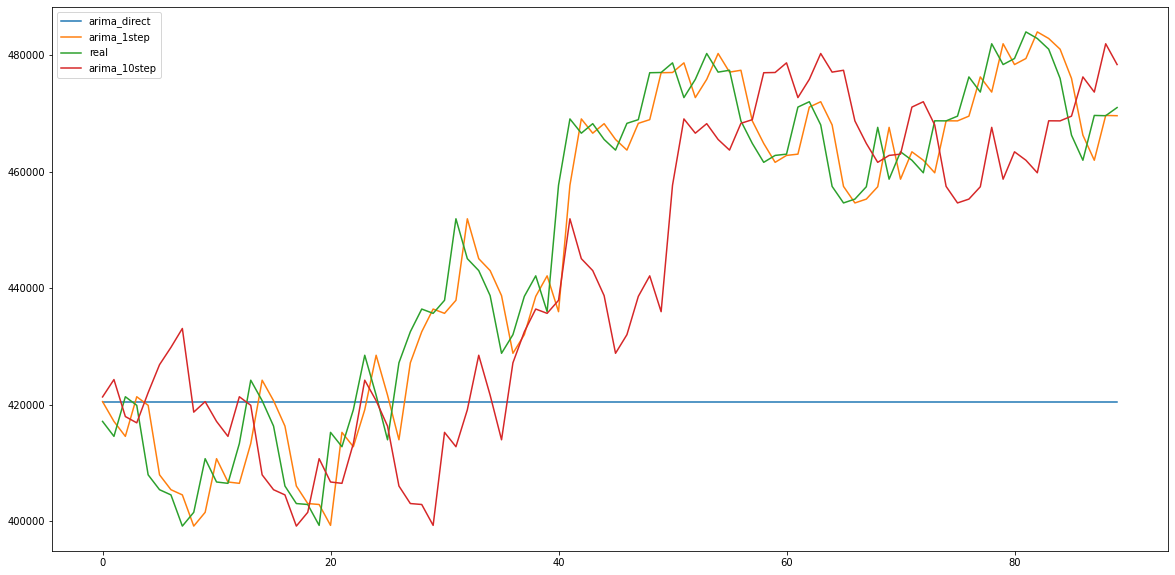

In [30]:
df_arima_berkshire.plot()

In [31]:
df_arima_berkshire.head()

,arima_direct,arima_1step,real,arima_10step
0,420500.0,420500.0,417103.0,421308.0
1,420500.0,417103.0,414537.0,424290.0
2,420500.0,414537.0,421339.0,417940.0
3,420500.0,421339.0,419869.0,416860.0
4,420500.0,419869.0,407930.0,422047.0


## Visão das previsões junto com os dados reais da Berkshire Hathaway

A visão tem relação somente com os últimos 3 anos

O tamanho utilizado para testes foi 90

(810,) (810,) (90,) (90,)


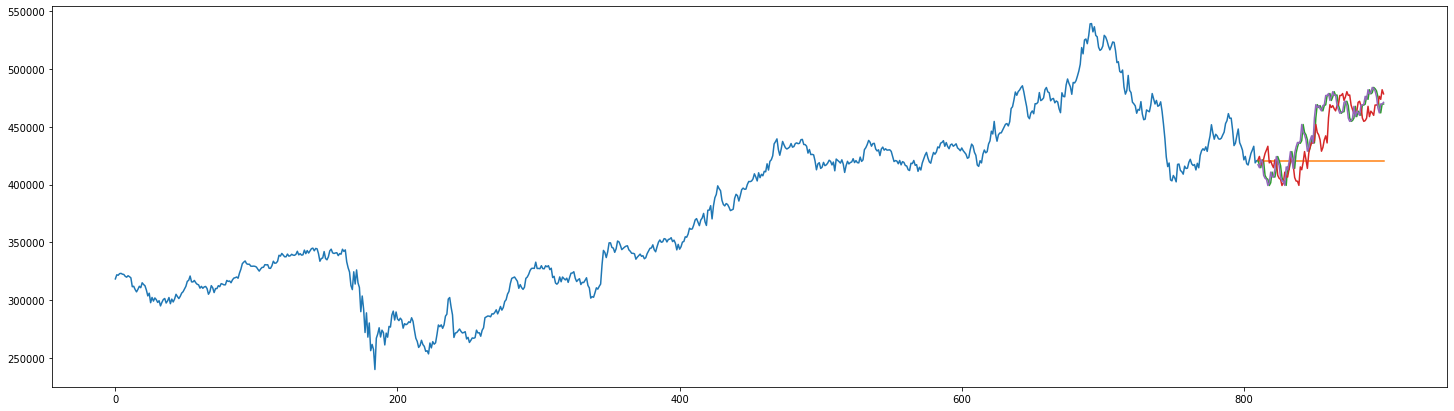

In [32]:
plot_predict(ts_berkshire, df_arima_berkshire, 90)

## Cálculo do Erro Médio quadrático

In [33]:
for name in ['arima_direct', 'arima_1step', 'arima_10step']:
  print(name,':',mean_square_error(df_arima_berkshire['real'], df_arima_berkshire[name]))

arima_direct : 1453131724.6777778
arima_1step : 40098560.8
arima_10step : 298611831.4444444


## Análise uma série temporal do pydataset - 'UKDriverDeaths'

In [34]:
timeseries_titles = ['AirPassengers', 'nottem', 'ambientNOxCH', 'acme', 'sunspot.year', 'UKDriverDeaths', 
                    'USAccDeaths', 'UKgas', 'JohnsonJohnson', 'Nile', 'LakeHuron', 'austres', 
                    'lynx', 'deaths', 'drivers']
                    
df_ukdrivers = data('UKDriverDeaths')

print(len(timeseries_titles))

15


In [35]:
data('UKDriverDeaths', show_doc=True )

UKDriverDeaths

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

##  Road Casualties in Great Britain 1969–84

### Description

`UKDriverDeaths` is a time series giving the monthly totals of car drivers in
Great Britain killed or seriously injured Jan 1969 to Dec 1984. Compulsory
wearing of seat belts was introduced on 31 Jan 1983.

`Seatbelts` is more information on the same problem.

### Usage

    UKDriverDeaths
    Seatbelts

### Format

`Seatbelts` is a multiple time series, with columns

`DriversKilled`

car drivers killed.

`drivers`

same as `UKDriverDeaths`.

`front`

front-seat passengers killed or seriously injured.

`rear`

rear-seat passengers killed or seriously injured.

`kms`

distance driven.

`PetrolPrice`

petrol price.

`VanKilled`

number of van (‘light goods vehicle’) drivers.

`law`

0/1: was the law in effect that month?

### Source

Harvey, A.C. (1989) _Forecasting, Structural Time Series Models and the Kalman
Filter._ Ca

In [36]:
df_ukdrivers['date'] = pd.date_range(start ='1969-01-01', end='1985-01-01', freq='M')

In [37]:
df_ukdrivers.set_index('date', inplace=True)

**Análise**:

No gráfico de mortes mensais no Reino Unido não há tendência, mas aparentemente existe uma sazonalidade e ciclo. Confirmado nos gráficos de média mensal.

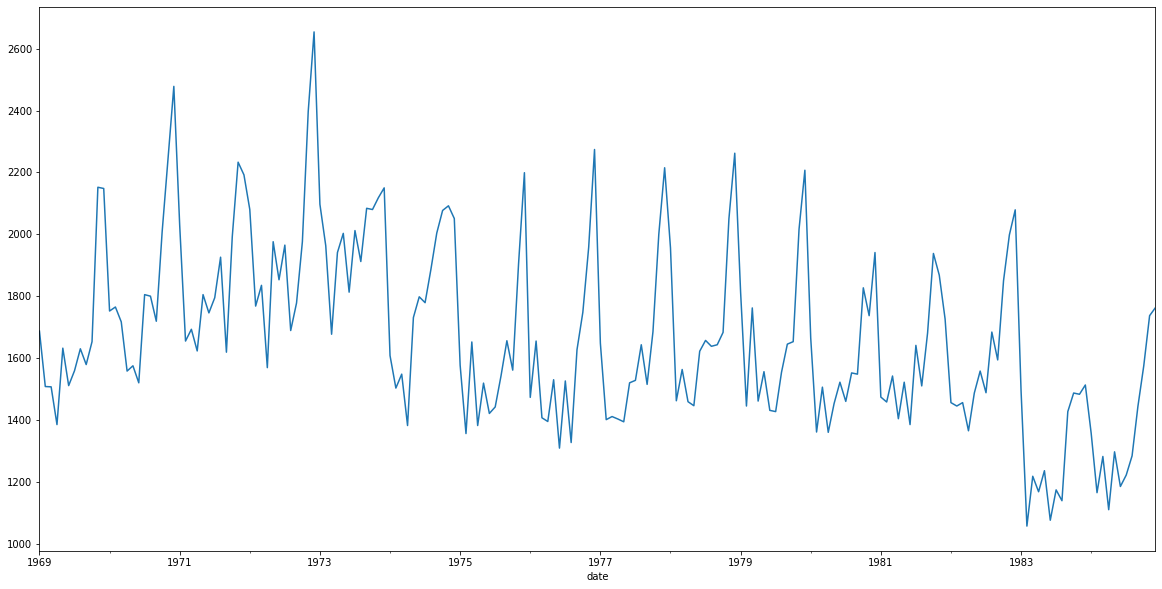

In [38]:
df_ukdrivers['UKDriverDeaths'].plot()

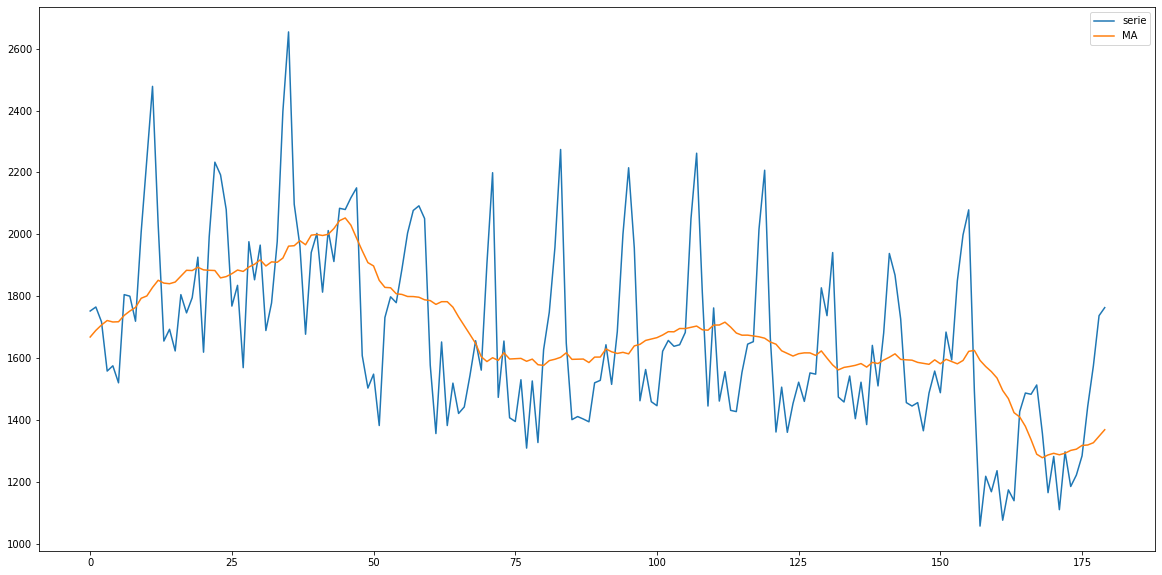

In [39]:
ts = df_ukdrivers['UKDriverDeaths']
ma_size=12
show_trend(ts, ma_size)

**Análise**:

No gráfico de correlação acumulada, aparentemente existe uma correlação muito forte a cada 12 meses, indicando uma sazonalidade.

Na análise parcial da correlação, podemos ver que o gráfico apresenta uma característica de sazonalidade também, mas com correlação mais fraca nos depois de 12 e 24 meses.

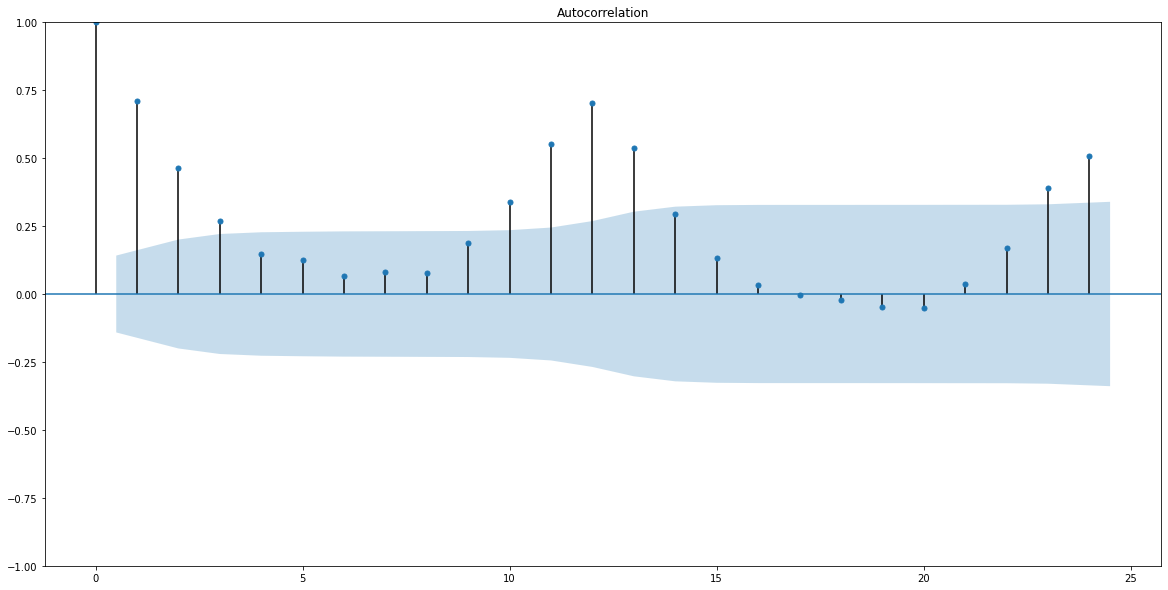

In [40]:
sm.graphics.tsa.plot_acf(df_ukdrivers['UKDriverDeaths'].values.squeeze(), lags=24)

plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


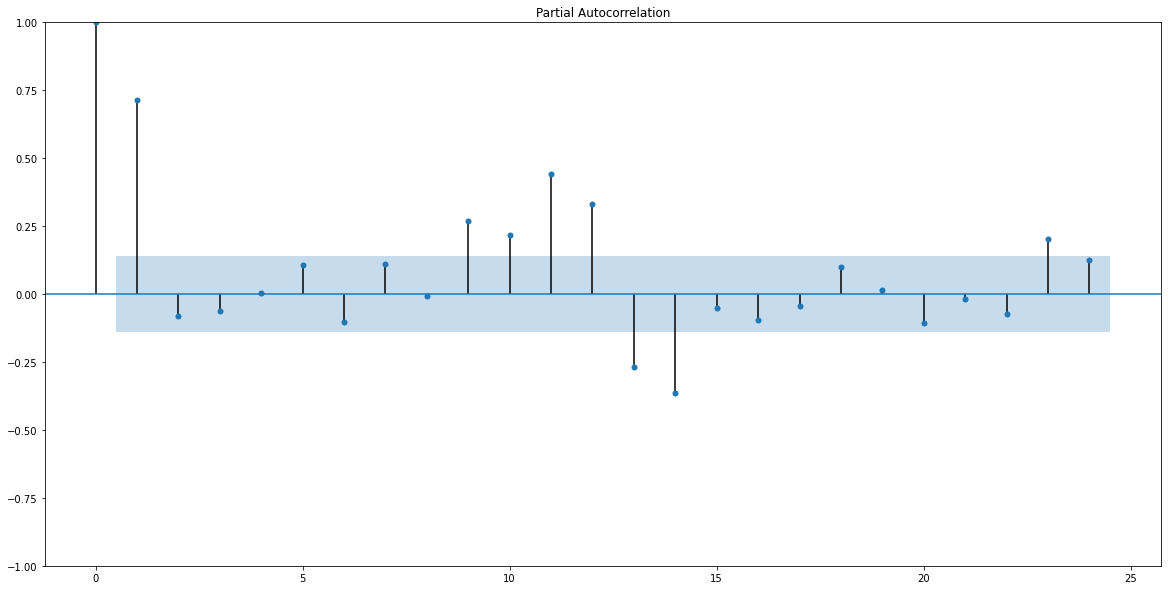

In [41]:
sm.graphics.tsa.plot_pacf(df_ukdrivers['UKDriverDeaths'].values.squeeze(), lags=24)

plt.show()

**Análise com função KPSSTest - UKDriverDeaths**

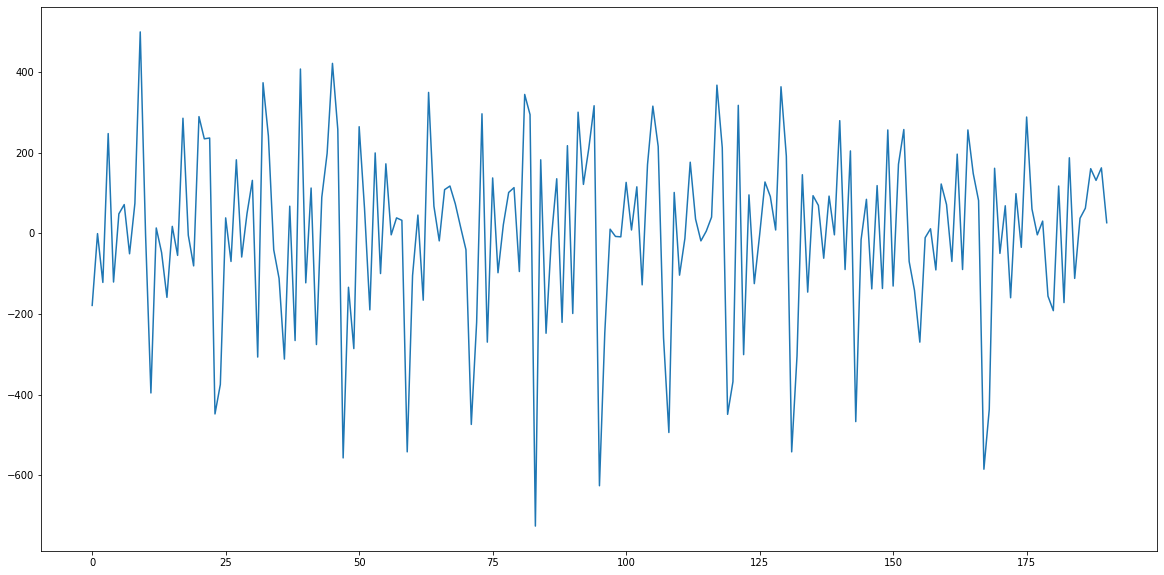

In [42]:
diff_ukdrivers = difference(df_ukdrivers['UKDriverDeaths']) # ou ts.diff()
diff_ukdrivers.plot()
plt.show()

In [43]:
kps.should_diff(df_ukdrivers['UKDriverDeaths'])

(0.01, True)

**Análise**

Plot do ACF para o primeiro diff da série UKDriverDeaths. 

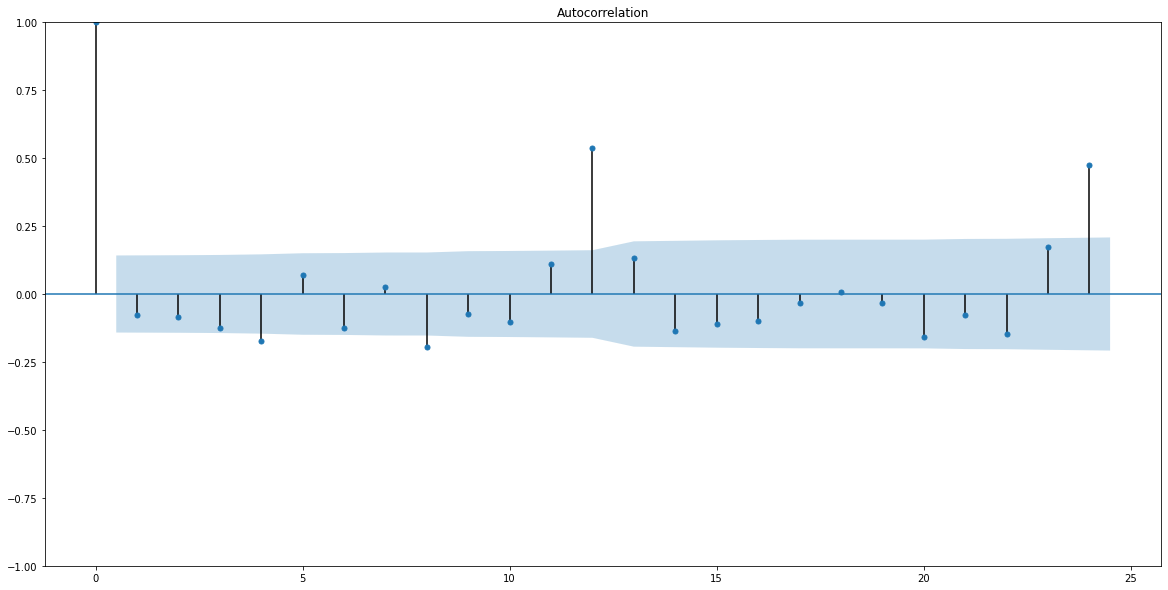

In [44]:
sm.graphics.tsa.plot_acf(diff_ukdrivers, lags=24)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


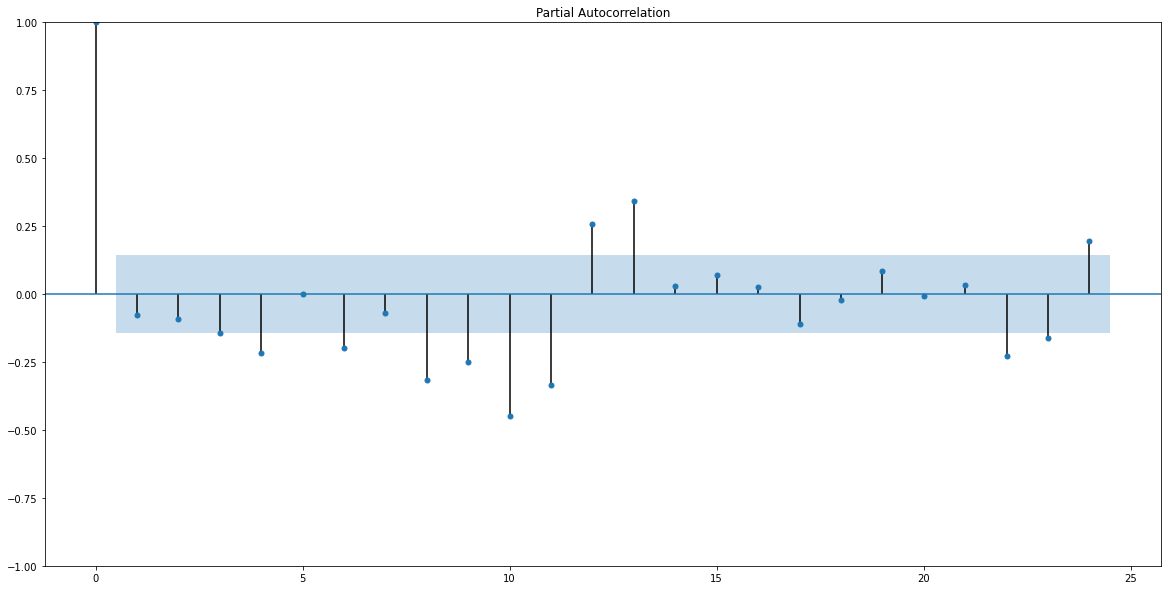

In [45]:
sm.graphics.tsa.plot_pacf(diff_ukdrivers, lags=24)
plt.show()

In [46]:
kps.should_diff(diff_ukdrivers)

(0.1, False)

**Anáise**

De acordo com a função de KPSSTest, o dados de acidentes do dataset UKDriverDeaths precisaria da função diff, mas depois do primeiro diff, o KPSSTest já indicou False no teste.

##Criação do modelo com auto_arima - UKDriverDeaths## 

In [47]:
auto_arima(df_ukdrivers['UKDriverDeaths'], # X=None,
           start_p=2, d=None, start_q=2, 
           max_p=5, max_d=2, max_q=5, start_P=1, D=None,
           start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=12, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2607.707, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2538.987, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2563.110, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2605.707, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2608.535, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2528.667, Time=0.84 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2523.079, Time=0.82 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2520.319, Time=0.47 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2564.471, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2522.829, Time=0.93 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2557.524, Time=0.72 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=2520.990, Time=0.97 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2530.955, Time=0.31 sec
 ARIMA(2,1,0)(1,0,1)[12]

ARIMA(maxiter=10, order=(0, 1, 0), scoring_args={},
      seasonal_order=(1, 0, 2, 12), suppress_warnings=True,
      with_intercept=False)

## Predict com auto_arima e 1 step and direct

In [106]:
df_arima_ukdrivers = arima_fit_predict(df_ukdrivers['UKDriverDeaths'], 12, 28)

training shape (164,)
test shape (28,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2154.032, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2232.950, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2169.136, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2188.922, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2230.950, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2175.145, Time=0.16 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2161.230, Time=0.19 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2157.420, Time=0.45 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2154.785, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2207.150, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2173.860, Time=0.40 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2159.003, Time=0.42 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2156.701, Time=0.48 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2155

  0%|          | 0/28 [00:00<?, ?it/s]

test 1647.0673178170493


  4%|▎         | 1/28 [00:00<00:11,  2.37it/s]

test 1756.854601534328


  7%|▋         | 2/28 [00:00<00:10,  2.37it/s]

test 1916.7197361270912


 11%|█         | 3/28 [00:01<00:10,  2.35it/s]

test 1916.2207829161364


 14%|█▍        | 4/28 [00:01<00:10,  2.24it/s]

test 1721.9958251494932


 18%|█▊        | 5/28 [00:02<00:10,  2.27it/s]

test 1389.7048800997002


 21%|██▏       | 6/28 [00:02<00:09,  2.29it/s]

test 1363.9220936907377


 25%|██▌       | 7/28 [00:03<00:09,  2.30it/s]

test 1156.9196104709738


 29%|██▊       | 8/28 [00:03<00:08,  2.26it/s]

test 1423.9360820901102


 32%|███▏      | 9/28 [00:03<00:08,  2.29it/s]

test 1311.359493007113


 36%|███▌      | 10/28 [00:04<00:07,  2.29it/s]

test 1301.9317786069166


 39%|███▉      | 11/28 [00:04<00:07,  2.29it/s]

test 1294.977862470254


 43%|████▎     | 12/28 [00:05<00:07,  2.26it/s]

test 1309.2864171323893


 46%|████▋     | 13/28 [00:05<00:06,  2.18it/s]

test 1545.9893770790495


 50%|█████     | 14/28 [00:06<00:06,  2.17it/s]

test 1684.3711722710218


 54%|█████▎    | 15/28 [00:06<00:05,  2.18it/s]

test 1663.3251923790522


 57%|█████▋    | 16/28 [00:07<00:05,  2.18it/s]

test 1145.5690816276556


 61%|██████    | 17/28 [00:07<00:05,  2.16it/s]

test 1095.3455183267035


 64%|██████▍   | 18/28 [00:08<00:04,  2.16it/s]

test 1192.6383697306069


 68%|██████▊   | 19/28 [00:08<00:04,  2.12it/s]

test 1151.5559403631778


 71%|███████▏  | 20/28 [00:09<00:03,  2.15it/s]

test 1133.9348476297878


 75%|███████▌  | 21/28 [00:09<00:03,  2.11it/s]

test 1204.5837256955413


 79%|███████▊  | 22/28 [00:09<00:02,  2.09it/s]

test 1162.7333625148258


 82%|████████▏ | 23/28 [00:10<00:02,  2.09it/s]

test 1254.2896881514741


 86%|████████▌ | 24/28 [00:10<00:01,  2.10it/s]

test 1270.2766625557867


 89%|████████▉ | 25/28 [00:11<00:01,  2.08it/s]

test 1549.0780863107377


 93%|█████████▎| 26/28 [00:11<00:00,  2.07it/s]

test 1578.4561365980883


 96%|█████████▋| 27/28 [00:12<00:00,  2.04it/s]

test 1782.1177311568476


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


##Predict com auto_arima e 10 steps.#

In [49]:
df_arima_ukdrivers['arima_10step'] = arima_horizon_fit_predict(df_ukdrivers['UKDriverDeaths'], 12, 28, 10)

training shape (155,)
test shape (37,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2042.835, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2115.528, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2053.714, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2073.538, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2113.533, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2062.468, Time=0.14 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2048.565, Time=0.18 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2045.565, Time=0.45 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2044.305, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2094.160, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2060.842, Time=0.39 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2046.491, Time=0.38 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2044.848, Time=0.48 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2046

  0%|          | 0/37 [00:00<?, ?it/s]

fim do treino 155


  3%|▎         | 1/37 [00:00<00:07,  5.00it/s]

fim do treino 156


  5%|▌         | 2/37 [00:00<00:06,  5.04it/s]

fim do treino 157


  8%|▊         | 3/37 [00:00<00:07,  4.73it/s]

fim do treino 158


 14%|█▎        | 5/37 [00:01<00:06,  4.83it/s]

fim do treino 159
fim do treino 160


 19%|█▉        | 7/37 [00:01<00:06,  4.97it/s]

fim do treino 161
fim do treino 162


 24%|██▍       | 9/37 [00:01<00:05,  5.00it/s]

fim do treino 163
fim do treino 164


 27%|██▋       | 10/37 [00:02<00:05,  5.05it/s]

fim do treino 165


 32%|███▏      | 12/37 [00:02<00:05,  4.94it/s]

fim do treino 166


 35%|███▌      | 13/37 [00:02<00:04,  4.95it/s]

fim do treino 167
fim do treino 168


 38%|███▊      | 14/37 [00:02<00:04,  4.96it/s]

fim do treino 169


 41%|████      | 15/37 [00:03<00:04,  4.82it/s]

fim do treino 170


 46%|████▌     | 17/37 [00:03<00:04,  4.88it/s]

fim do treino 171
fim do treino 172


 51%|█████▏    | 19/37 [00:03<00:03,  4.88it/s]

fim do treino 173
fim do treino 174


 54%|█████▍    | 20/37 [00:04<00:03,  4.89it/s]

fim do treino 175


 59%|█████▉    | 22/37 [00:04<00:03,  4.87it/s]

fim do treino 176
fim do treino 177


 65%|██████▍   | 24/37 [00:04<00:02,  4.90it/s]

fim do treino 178
fim do treino 179


 68%|██████▊   | 25/37 [00:05<00:02,  4.87it/s]

fim do treino 180


 73%|███████▎  | 27/37 [00:05<00:02,  4.81it/s]

fim do treino 181
fim do treino 182


 76%|███████▌  | 28/37 [00:05<00:01,  4.72it/s]

fim do treino 183


 78%|███████▊  | 29/37 [00:05<00:01,  4.71it/s]

fim do treino 184


 81%|████████  | 30/37 [00:06<00:01,  4.66it/s]

fim do treino 185


 84%|████████▍ | 31/37 [00:06<00:01,  4.67it/s]

fim do treino 186


 86%|████████▋ | 32/37 [00:06<00:01,  4.66it/s]

fim do treino 187


 89%|████████▉ | 33/37 [00:06<00:00,  4.59it/s]

fim do treino 188


 92%|█████████▏| 34/37 [00:07<00:00,  4.62it/s]

fim do treino 189


 95%|█████████▍| 35/37 [00:07<00:00,  4.55it/s]

fim do treino 190


 97%|█████████▋| 36/37 [00:07<00:00,  4.59it/s]

fim do treino 191


100%|██████████| 37/37 [00:07<00:00,  4.76it/s]


## Plot das previões com auto_arima: Direct, 1 step, 10 steps e real.

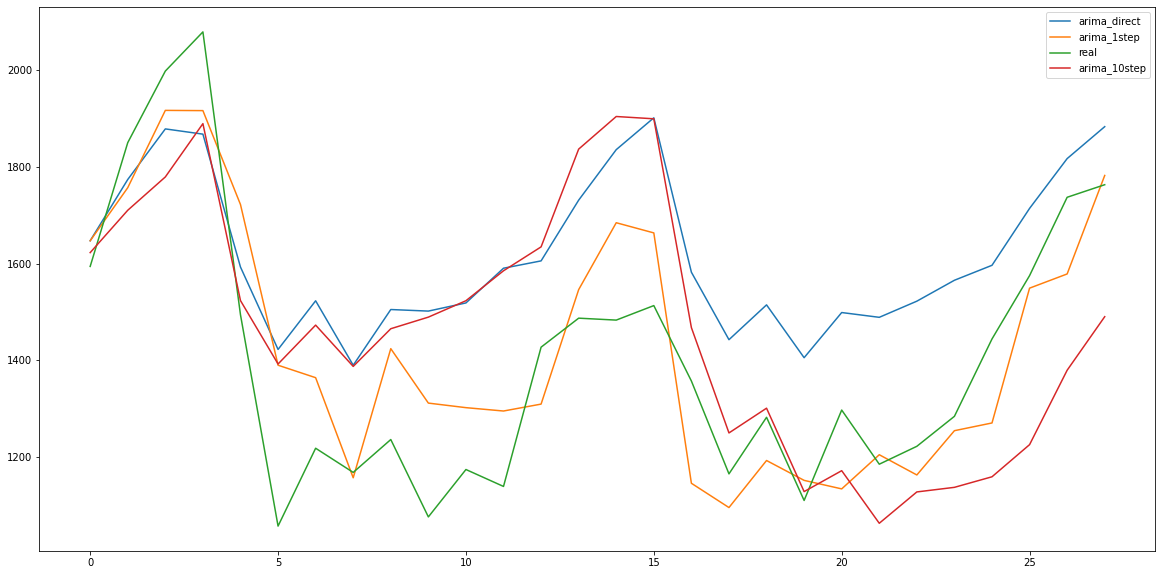

In [50]:
df_arima_ukdrivers.plot()
plt.show()

In [51]:
df_arima_ukdrivers.head()

,arima_direct,arima_1step,real,arima_10step
0,1647.067318,1647.067318,1594,1622.541527
1,1773.800280,1756.854602,1850,1710.168409
2,1878.409270,1916.719736,1998,1779.060289
3,1867.572143,1916.220783,2079,1889.312777
4,1592.733404,1721.995825,1494,1523.367674


In [52]:
df_arima_ukdrivers.shape

(28, 4)

##Cálculo do Erro Médio Quadrático  - UKDriversDeath##

In [53]:
for name in ['arima_direct', 'arima_1step', 'arima_10step']:
  print(name,':',mean_square_error(df_arima_ukdrivers['real'], df_arima_ukdrivers[name]))

arima_direct : 68914.31902311773
arima_1step : 20984.640594581946
arima_10step : 66186.02497665779


##Plot das previões realizadas junto com os dados reais através do tempo.

(164,) (164,) (28,) (28,)


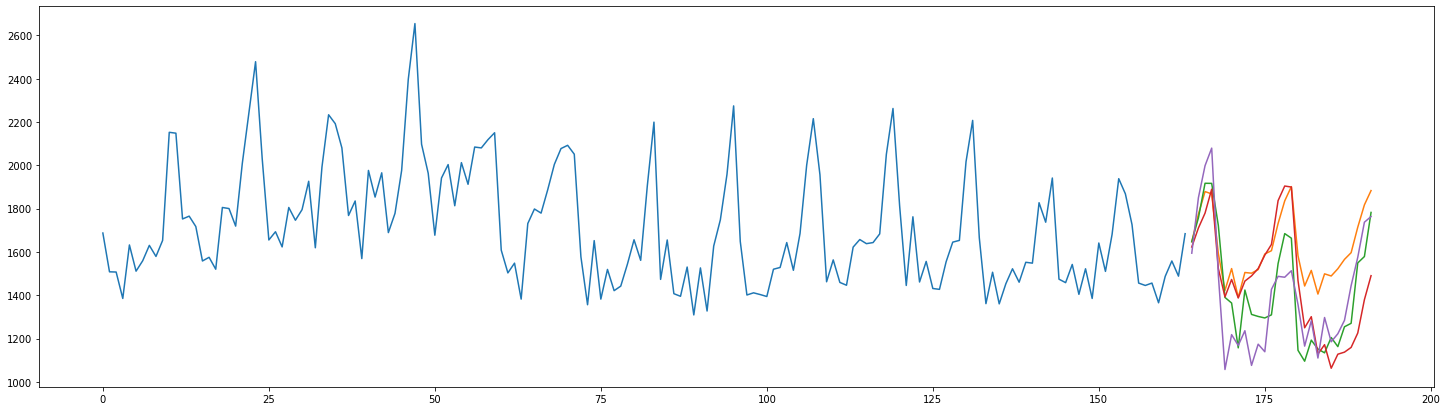

In [54]:
plot_predict(df_ukdrivers['UKDriverDeaths'], df_arima_ukdrivers, 28)

## Análise da série temporal "sem_nome"

In [55]:
from google.colab import drive
drive.mount('/content/gdrive')
df_sem_nome = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dados/sem_nome.csv')

Mounted at /content/gdrive


In [88]:
#df_sem_nome = pd.read_csv('sem_nome.csv')
#df_sem_nome
df_sem_nome.shape

(1000, 2)

**Análise**:

Na plotagem de todos os dados temporais, aparentemente não há uma tendência, mesmo fazendo um corte dos últimos 200 dados, difícil analisar se existe uma sazonalidade e ciclos.

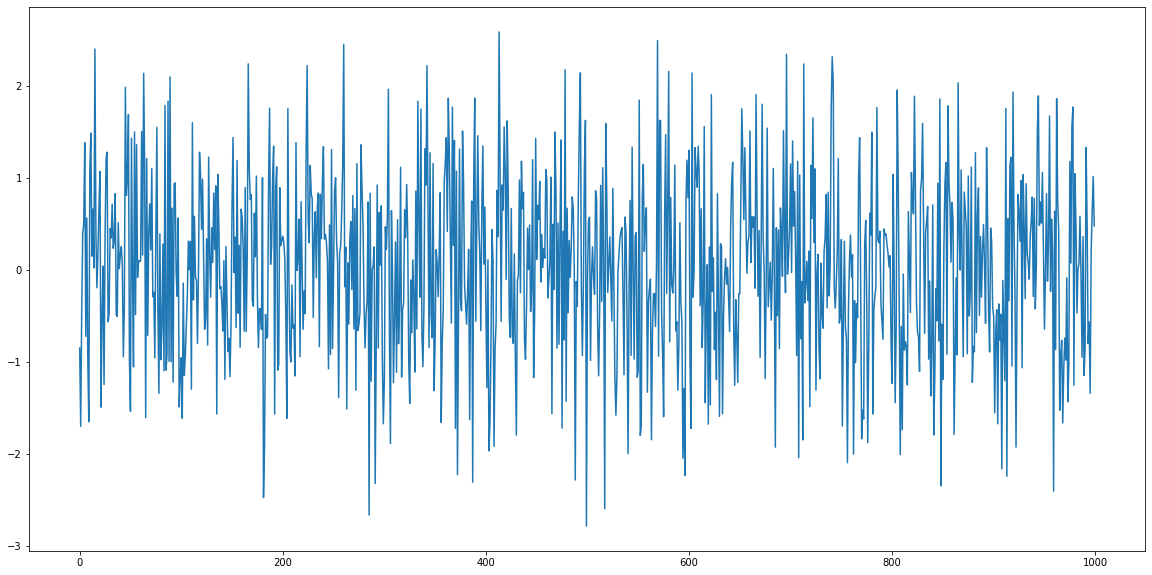

In [57]:
df_sem_nome['actual'].plot()

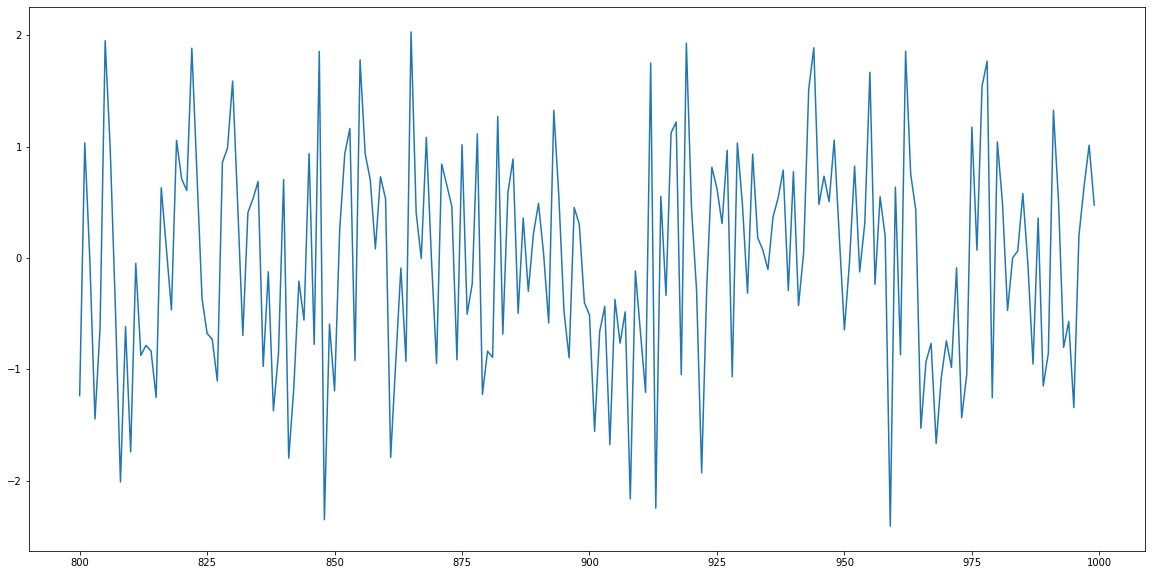

In [58]:
df_sem_nome['actual'].iloc[-200:].plot()

**Análise**:


Tanto no gráfico de correlação acumulada quanto na correlação parcial, não existe correlação entre os dados, nem mesmo no t-1. Média móvel bem próxima de zero indicando um caraterística de "Ruído Branco".

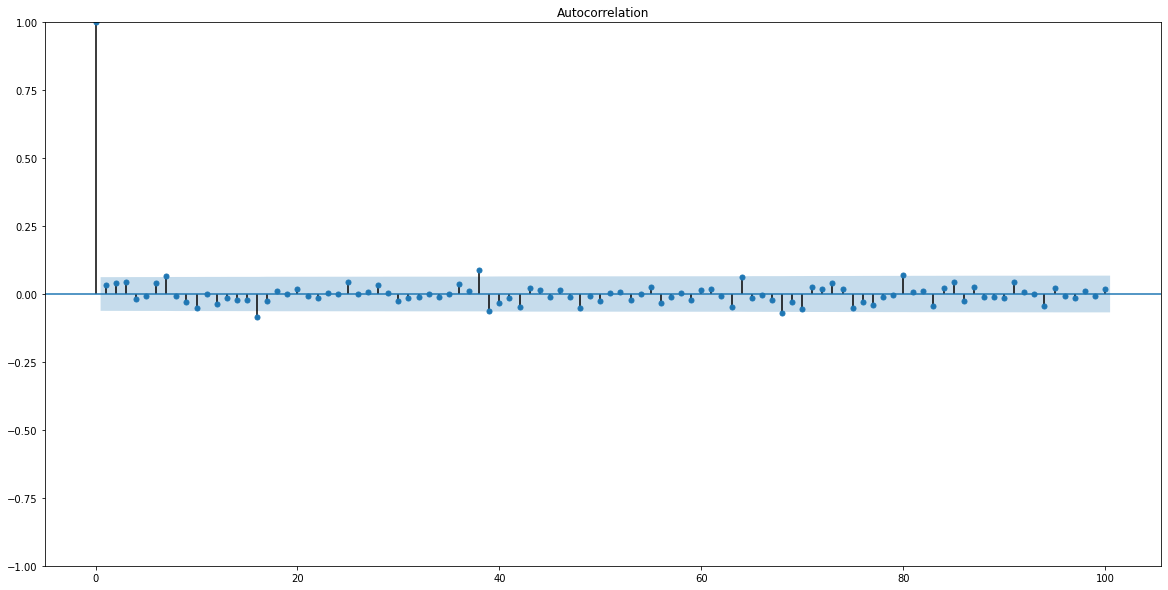

In [59]:
sm.graphics.tsa.plot_acf(df_sem_nome['actual'].values.squeeze(), lags=100)

plt.show()

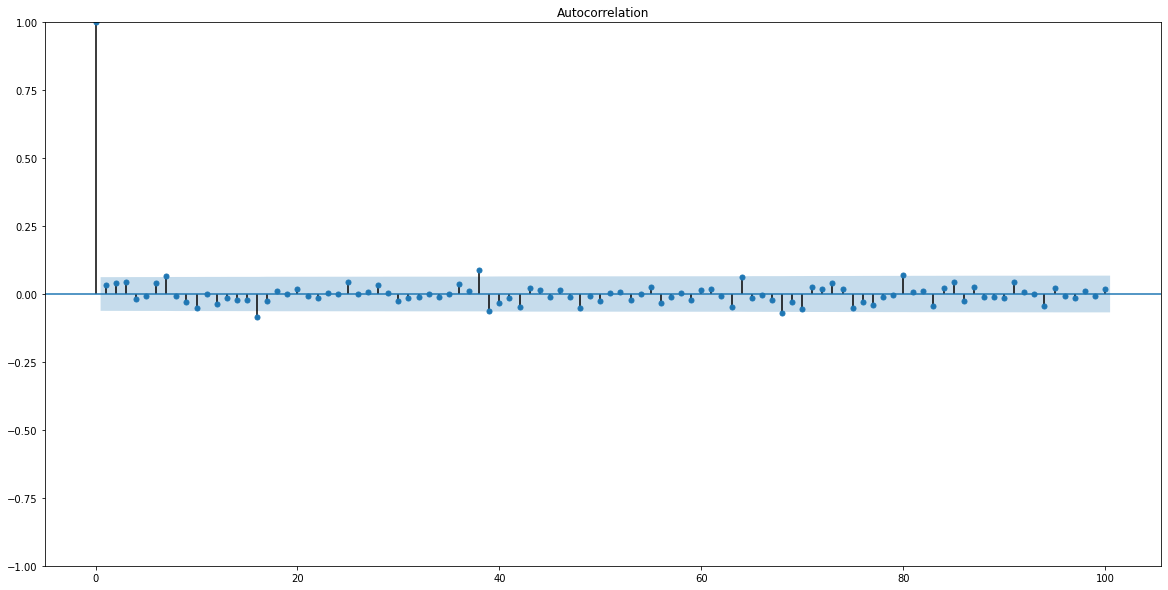

In [60]:
sm.graphics.tsa.plot_acf(df_sem_nome['actual'].values.squeeze(), lags=100)

plt.show()

**Análise com função KPSSTest - sem_nome dataset**

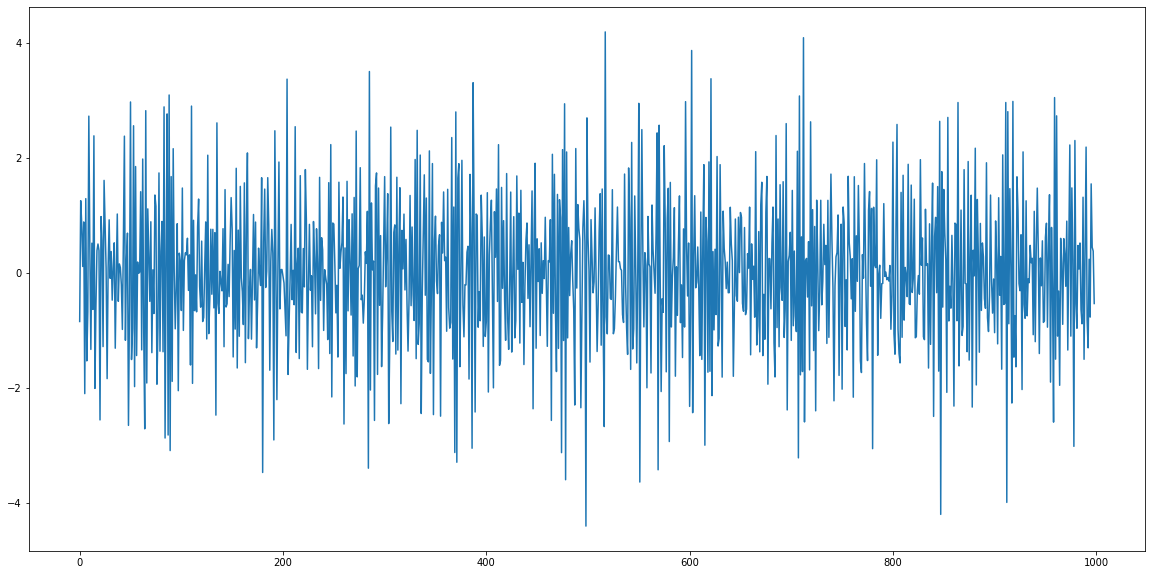

In [61]:
diff_semnome = difference(df_sem_nome['actual']) # ou ts.diff()
diff_semnome.plot()
plt.show()

In [62]:
kps.should_diff(df_sem_nome['actual'])

(0.1, False)

**Análise**

Verificando o KPSSTest para o dataset sem_nome, podemos ver que não seria necessário fazer o diff no dataset original.

Plotando os gráficos de ACF e PACF para o diff do dataset.

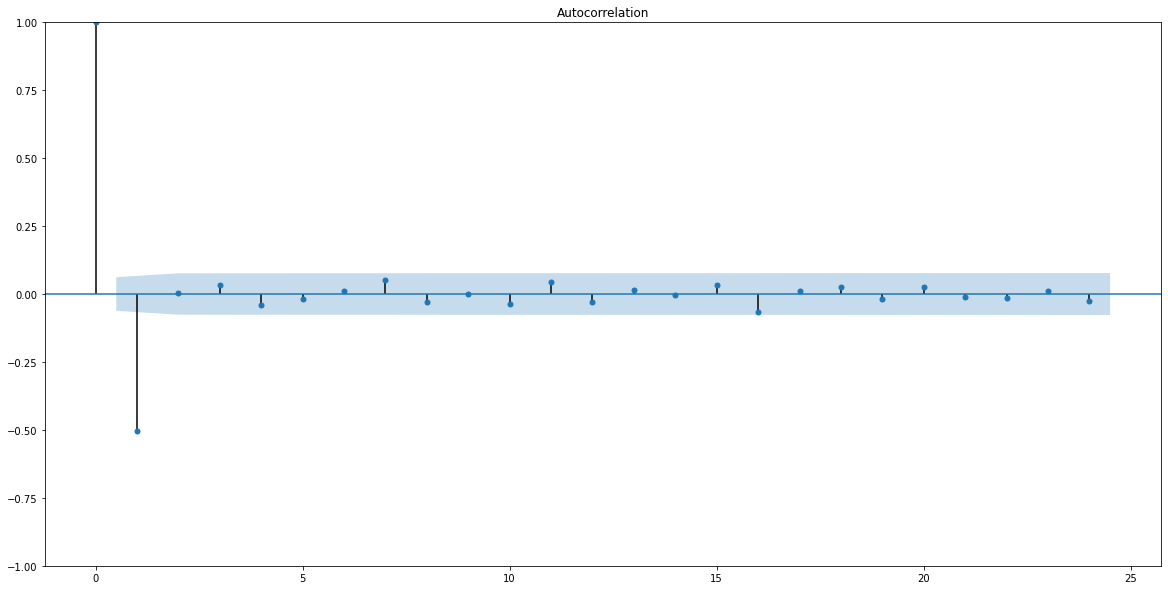

In [63]:
sm.graphics.tsa.plot_acf(diff_semnome, lags=24)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


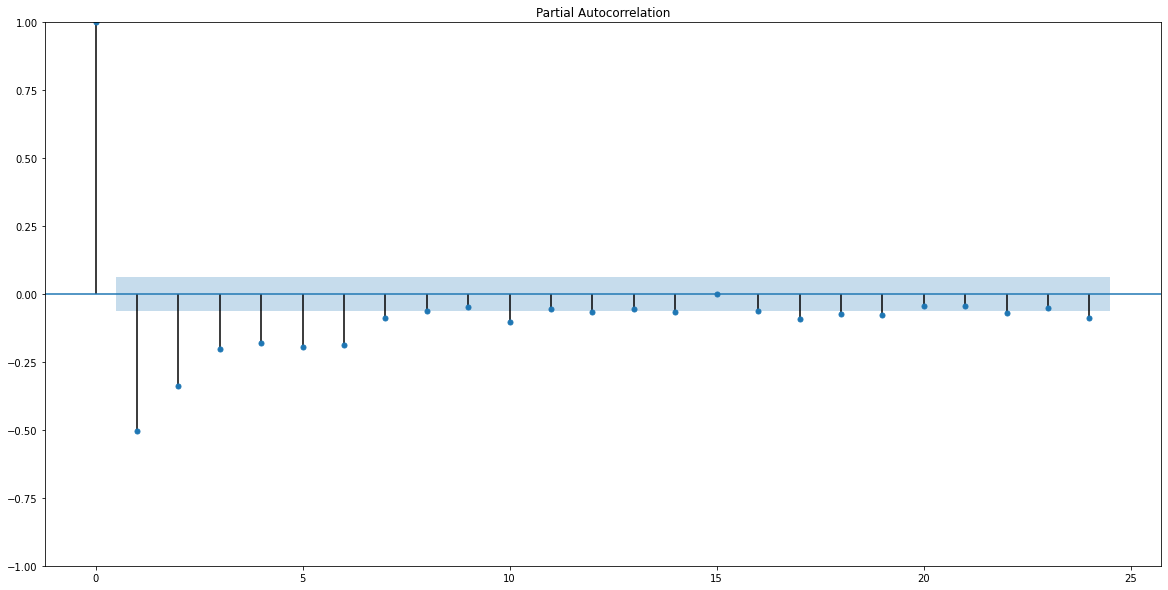

In [64]:
sm.graphics.tsa.plot_pacf(diff_semnome, lags=24)
plt.show()

##Análise ARIMA e ARIMA Sazonal##

In [65]:
white_noise = np.random.normal(size=1000)

In [66]:
c  = 10
ar1 = [1]
peso = 0.5

for i in range(0, len(white_noise)):
  ar1.append(c  + (peso*ar1[i]) + white_noise[i])


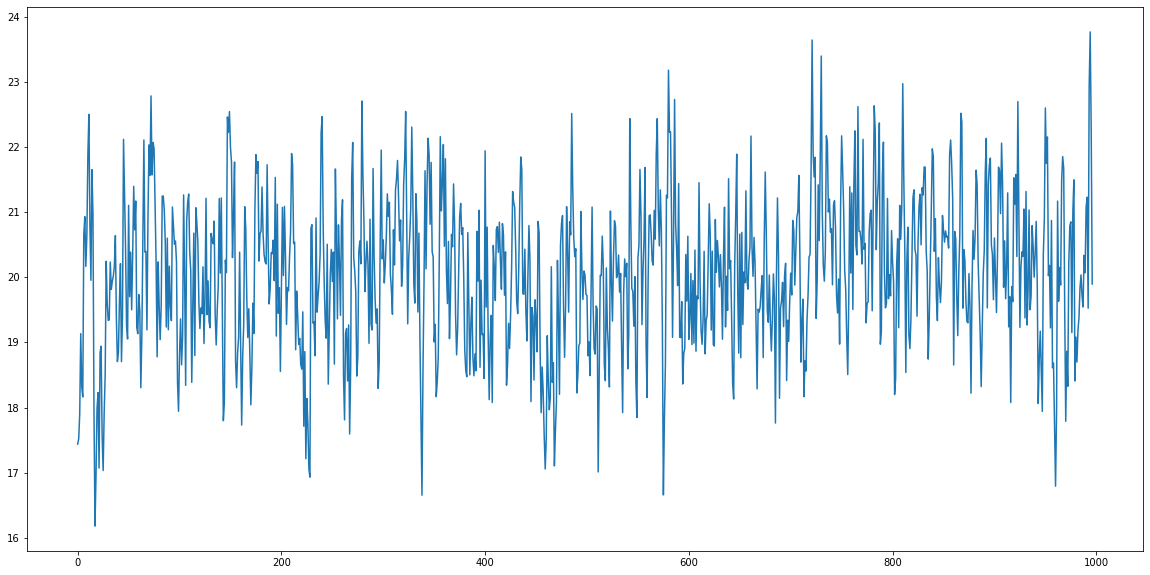

In [67]:
pd.Series(ar1[4:]).plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


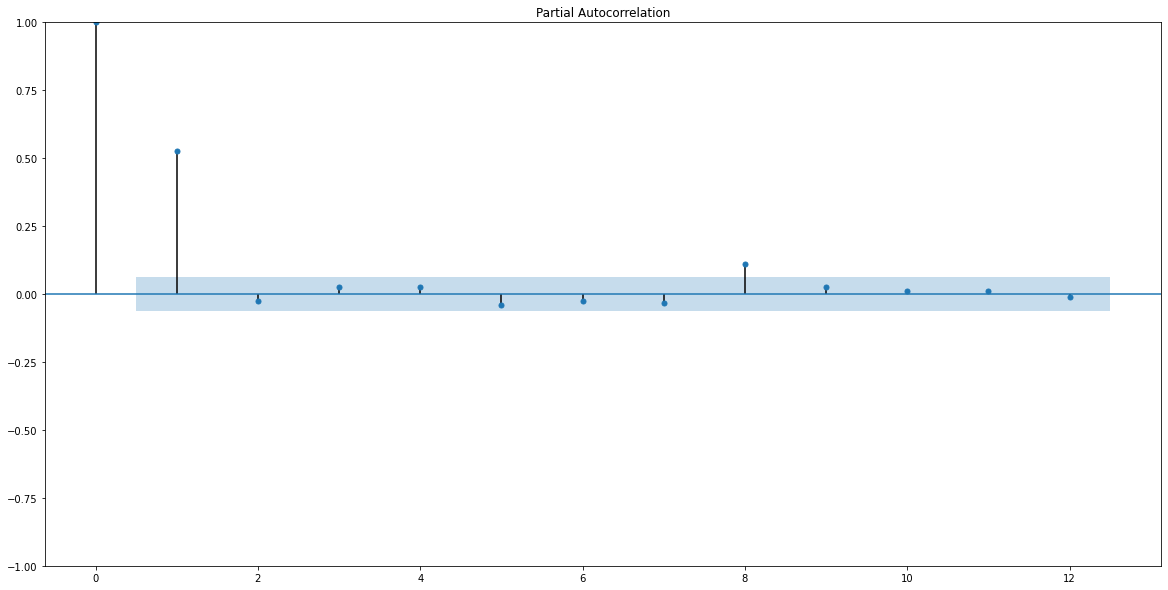

In [68]:
sm.graphics.tsa.plot_pacf(ar1[4:], lags=12)
plt.show()

In [69]:
c  = 10
ar2 = [1, 3]
peso1 = 0.4
peso2 = - 0.5 

for i in range(0, len(white_noise)):
  ar2.append(c  + (peso2*ar2[i]) + (peso1*ar2[i+1]) + white_noise[i])


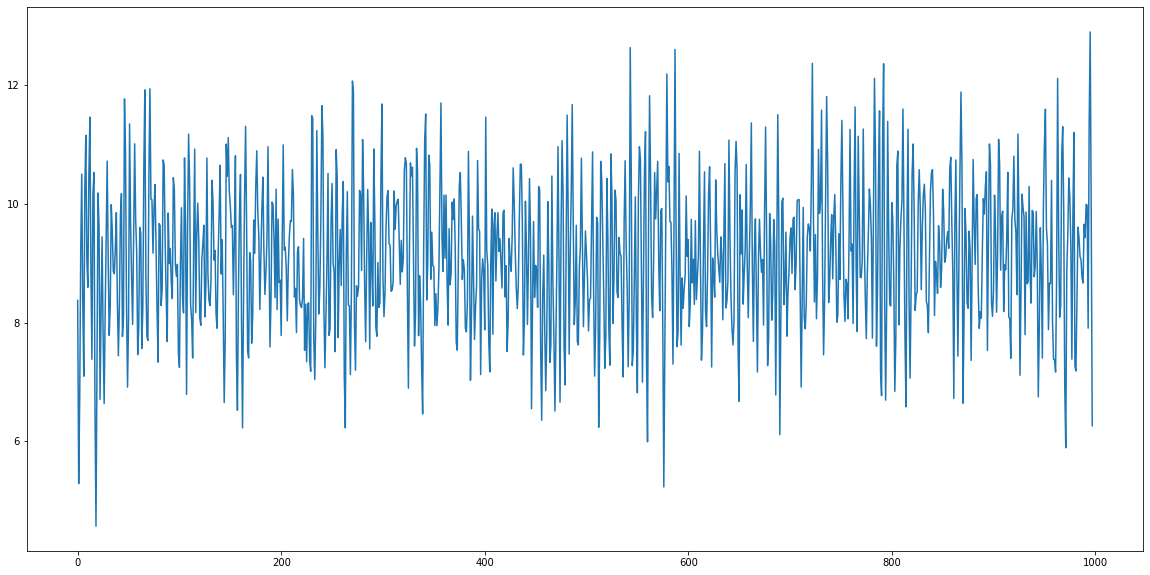

In [70]:
pd.Series(ar2[4:]).plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


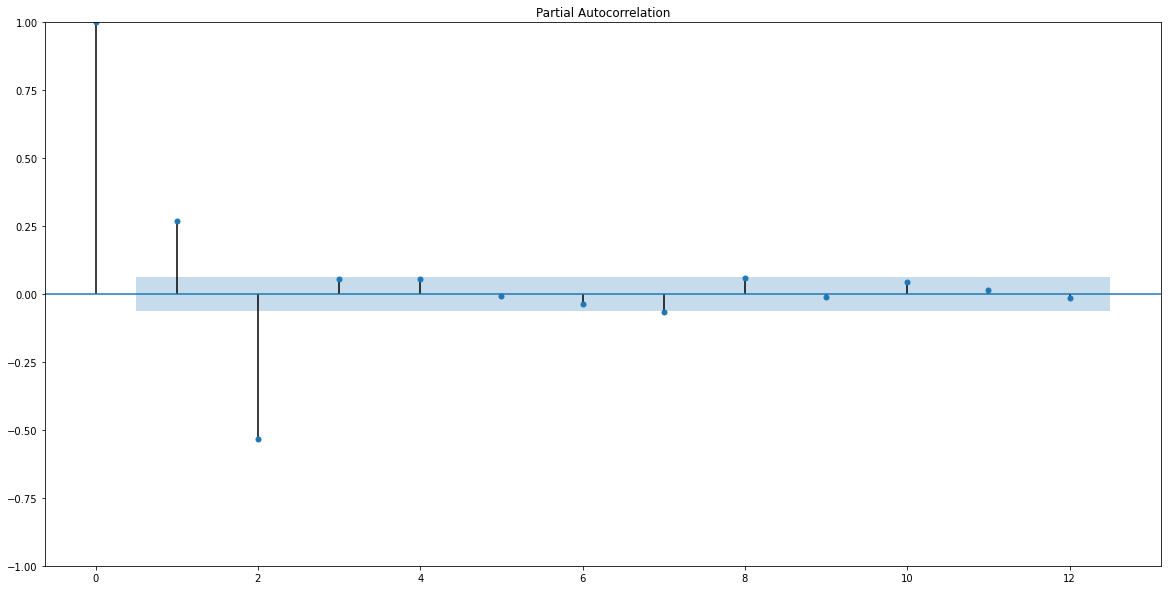

In [71]:
sm.graphics.tsa.plot_pacf(ar2[4:], lags=12)
plt.show()